In [1]:
import torch
import numpy as np
import os
import glob
import pickle
import matplotlib.pyplot as plt
import torch.nn as nn
data_dir='/home/yyang/research/multimeidia/PreprocessedEEG_Filt200Hz_NoFixEog/'
def get_eeg_paths(folder_path):
    file_extension = '.pkl'  # 指定后缀名，比如txt, pdf, jpg等
    file_paths=[]
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(file_extension):
                file_paths.append(os.path.join(root, file))
    return file_paths
eeg_paths=get_eeg_paths(data_dir)
# 找到前89个视频对应的EEG
eeg_signal89={}
for i,path in enumerate(eeg_paths):
    name=os.path.split(os.path.dirname(path))[-1]
    # print(name)
    if int(name)<89:
        with open(path, 'rb') as f:
            obj = pickle.load(f)
            eeg_signal89[int(name)]=obj
keys_list=np.array(list(eeg_signal89.keys()))
# test_ids= [83 ,21, 80,  1 ,64]#np.random.choice(keys_list,size=5)
# train_ids=np.setdiff1d(keys_list,test_ids)
# print(train_ids,test_ids)

[ 2  3  4  6  7  8  9 10 14 15 17 19 23 24 25 26 28 32 34 35 36 37 39 40
 41 43 46 47 48 49 50 52 53 55 56 57 58 65 66 68 69 70 73 76 78 79 81 82
 84 85 86] [83, 21, 80, 1, 64]


In [10]:
np.random.shuffle(keys_list)
all_ids=keys_list
train_ids=keys_list[:45]
val_ids=keys_list[45:50]
test_ids=keys_list[50:]
print(train_ids,val_ids,test_ids)

[53 46 65 26 76 32 19  6 24 49 40 57 34 56 70 15 23 58 78 69 66 55 17  7
  1 52  4 73 85 48 36 68 64 10 82 79 86 39 50 25  3 35 28 83 80] [41  2 21 47 37] [43  8 84 81 14  9]


In [2]:
import cv2
from IPython.display import Video
import os
from moviepy.editor import VideoFileClip

def mkdir(path):
    dirname=os.path.dirname(path)
    if dirname != '':
        if not os.path.exists(dirname):
            os.makedirs(dirname)
    return path
def process_video(path,store_path):
    video=VideoFileClip(path)
    w,h=clearity*16/9,clearity
    fps=25
    video = video.resize((w, h))
    # 修改视频的帧率
    video = video.set_fps(fps)
    video.write_videofile(store_path)
def extract_frames(video_path, output_dir):
    # 创建输出文件夹
    os.makedirs(output_dir, exist_ok=True)

    # 打开视频文件
    cap = cv2.VideoCapture(video_path)

    # 读取视频帧，直到到达视频的末尾
    while cap.isOpened():
        # 读取一帧
        ret, frame = cap.read()
        # 如果读取失败，退出循环
        if not ret:
            break
        # 构造输出文件路径
        filename = f"{int(cap.get(cv2.CAP_PROP_POS_FRAMES))}.jpg"
        output_path = os.path.join(output_dir, filename)
        # 保存帧到输出文件
        cv2.imwrite(output_path, frame)
    # 关闭视频文件
    cap.release()
def sort_by_tensor(a, b):
    # 对 b 张量进行排序
    sorted_indices = torch.argsort(b)

    # 使用排序后的索引对 a 张量进行重排
    a_sorted = a[sorted_indices]

    return a_sorted
watch_path = '/home/yyang/dataset/multi_media/选定视频'
video_name={'0':'伤心',
                        '1':'平和1_1',
                        '2':'开心',
                        '3':'愤怒1',
                        '4':'平和',
                        '5':'伤心2',
                        '6':'开心2',
                        '7':'愤怒2',
                        }
clearity=1080
# 把观看的视频转成相同的清晰度
folder_path='/home/yyang/dataset/multi_media/选定视频'
output_dir=f'/home/yyang/dataset/multi_media/chosen_video_{clearity}p'
file_paths=[]
for file_name in os.listdir(folder_path):
    # 检查文件名后缀是否为.mp4
    if file_name.endswith('.mp4'):
        new_file=os.path.join(output_dir, file_name)
        if not os.path.exists(new_file):
            # 构建完整的文件路径
            file_path = os.path.join(folder_path, file_name)
            file_paths.append(file_path)
            video = VideoFileClip(file_path)
            # 获取视频的宽度和高度
            width, height = video.size
            # 获取视频的帧率
            fps = video.fps
            duration=video.duration
            print(file_name,width, height,width/height,fps,duration)
            process_video(file_path,mkdir(new_file))
            print('process_video')
# 对所有帧提取出dino特征            
pretrained_weights_path="/home/yyang/research/multimeidia/cebra/dino_model/dino_model/dino_vitbase8_pretrain.pth"
for i in range(8):    
    source_video_path=f'/home/yyang/dataset/multi_media/chosen_video_{clearity}p/{video_name[str(i)]}.mp4'
    output_images_path=f'watch/{clearity}p_video89/{i}'
    output_feature_path=f"/home/yyang/research/multimeidia/cebra/{clearity}p_video89/img_features/{i}"
    try:        
        moviefeat=torch.load(os.path.join(output_feature_path,'trainfeat.pth'))#[5343, 768]
        movielabel=torch.load(os.path.join(output_feature_path,'trainlabels.pth'))
    except:
        # 如果load不了，就得自己提取。
        # extract_frames(source_video_path,output_images_path)
        print(f"CUDA_VISIBLE_DEVICES=6 python dino/extract_features.py \
        --pretrained_weights {pretrained_weights_path} \
        --arch vit_base --patch_size 8 --dump_features {output_feature_path} \
        --data_path {output_images_path} ")
        !CUDA_VISIBLE_DEVICES=6 python dino/extract_features.py \
        --pretrained_weights {pretrained_weights_path} \
        --arch vit_base --patch_size 8 --dump_features {output_feature_path} \
        --data_path {output_images_path} 


moviefeat_dict={}
for i in range(8):
    output_feature_path=f"/home/yyang/research/multimeidia/cebra/{clearity}p_video89/img_features/{i}"
    moviefeat=torch.load(os.path.join(output_feature_path,'trainfeat.pth'))#[5343, 768]
    movielabel=torch.load(os.path.join(output_feature_path,'trainlabels.pth'))
    moviefeat_sorted=sort_by_tensor(moviefeat,movielabel)
    moviefeat_dict[i]=moviefeat_sorted

In [3]:
# 定义数据集
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
import torch.utils.data._utils.collate

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, video_feat, all_eeg_signal,person_ids,seg_id=0, 
                 window_seconds=3,sep_seconds=1,test_sep_seconds=None,
                 fps=25,eeg_sr=1000,device='cpu'):
        """
        需要返回的是一段指定长度的EEG信号，对应的图片流，还有不匹配的相隔至少一定长度的图片流。这两个图片流要打乱顺序，以第一个是否匹配作为标签。
        """
        self.video_feat = video_feat  # [L,E]
        self.video_length=video_feat.shape[0]
        self.all_eeg_signal = all_eeg_signal
        self.person_ids = person_ids
        self.seg_id = seg_id
        self.person_num=len(person_ids)
        self.device=device
        self.window_length=int(window_seconds*eeg_sr)
        self.sr_times=eeg_sr/fps
        self.sep_seconds=sep_seconds
        if test_sep_seconds is None:
            self.test_sep_seconds=sep_seconds
        else:
            self.test_sep_seconds=test_sep_seconds
        self.sep_length=int(sep_seconds*eeg_sr)
        self.sep_img_length=int(sep_seconds*fps)
        self.test_sep_img_length=int(self.test_sep_seconds*fps)
        self.seg_img_length=int(window_seconds*fps)
        self.fps=fps
        self.eeg_sr=eeg_sr
        self.get_seg_num()
        
    def __getitem__(self, index):
        person_idx=index//self.seg_num
        seg_index=index%self.seg_num
        img_index=(self.seg_img_length+self.sep_img_length)*seg_index
        person_id=self.person_ids[person_idx]
        seg_start=int(img_index*self.sr_times)
        seg_start=seg_start if seg_start>0 else 0
        match=self.video_feat[img_index:img_index+self.seg_img_length]
        mismatch_start_index=img_index+self.seg_img_length+self.test_sep_img_length
        mismatch=self.video_feat[mismatch_start_index:mismatch_start_index+self.seg_img_length]
        mismatch=torch.tensor(mismatch,dtype=torch.float32,device=self.device)
        match=torch.tensor(match,dtype=torch.float32,device=self.device)
        assert match.shape[0]==self.seg_img_length and mismatch.shape[0]==self.seg_img_length, \
        f'mismatch_start_index:{mismatch_start_index},img_index:{img_index},self.video_length:{self.video_length},seg_len:{self.seg_img_length}'
        mismatch=torch.swapdims(mismatch,0,1)
        match=torch.swapdims(match,0,1)
        video_feat={}
        video_feat['v0']=match
        video_feat['v0_idx']=img_index
        video_feat['v1']=mismatch
        video_feat['v1_idx']=mismatch_start_index

        
        eeg_signal=self.all_eeg_signal[person_id][f'{self.seg_id}'][:,seg_start:seg_start+self.window_length]
        img_index=torch.tensor(img_index,dtype=torch.int64,device=self.device)
        person_id=torch.tensor(person_id,dtype=torch.int,device=self.device)
        person_idx=torch.tensor(person_idx,device=self.device)
        eeg_signal=torch.tensor(eeg_signal,dtype=torch.float32,device=self.device)
        eeg_signal=eeg_signal/eeg_signal.abs().max()*0.8
        eeg_signal=torch.nn.functional.pad(eeg_signal,(0,self.window_length-eeg_signal.shape[1]))  
        item={
            "img_idx":img_index, # int
            "person_id":person_id, # int real
            "person_nnid":person_idx, # int re-indexed
            "eeg":eeg_signal, # [64,400]
            **video_feat
        }
        return item

    def get_seg_num(self,):        
        seg_num=int(np.ceil((self.video_length-(self.seg_img_length*2+self.sep_img_length))/(self.seg_img_length+self.sep_img_length)))
        self.seg_num=seg_num
        
    def __len__(self):
        return self.seg_num*self.person_num

In [13]:
# 定义所有模型
from vit_pytorch import vit
class DilationModel(nn.Module):
    def __init__(self, eeg_input_dimension=64, env_input_dimension=1, layers=3, kernel_size=5, spatial_filters=8, dilation_filters=16, activation=nn.ReLU()):
        super(DilationModel, self).__init__()

        self.layers = layers
        self.kernel_size = kernel_size
        self.spatial_filters = spatial_filters
        self.dilation_filters = dilation_filters

        # Spatial convolution
        self.eeg_proj_1 = nn.Conv1d(eeg_input_dimension, spatial_filters, kernel_size=1)

        # Construct dilation layers
        self.eeg_dilation_layers = nn.ModuleList()
        self.env_dilation_layers = nn.ModuleList()
        stride_list=[2,4,5]
        for layer_index in range(layers):
            # dilation on EEG
            eeg_input_channel=spatial_filters if layer_index==0 else dilation_filters
            speech_input_channel=env_input_dimension if layer_index==0 else dilation_filters
            dilated_kernel_size = (kernel_size - 1) * kernel_size**layer_index + 1
            padding=dilated_kernel_size//2
            self.eeg_dilation_layers.append(
                nn.Conv1d(eeg_input_channel, dilation_filters, 
                          kernel_size=kernel_size, dilation=kernel_size**layer_index, 
                          stride=stride_list[layer_index], padding=padding))
            # Dilation on envelope data, share weights
            env_proj_layer = nn.Conv1d(speech_input_channel, dilation_filters, 
                                       kernel_size=kernel_size, dilation=1, 
                                       stride=1, padding=kernel_size//2)
            self.env_dilation_layers.append(env_proj_layer)

        # Comparison
        self.cos_layer_1 = nn.CosineSimilarity(dim=1)
        self.cos_layer_2 = nn.CosineSimilarity(dim=1)

        # Classification
        self.fc_layer = nn.Linear(dilation_filters*2, 1)
        self.sigmoid = nn.Sigmoid()

        activations = [activation] * layers
        self.activation=activations

    def forward(self, eeg, env1, env2):
        env_proj_1 = env1
        env_proj_2 = env2

        # Spatial convolution
        eeg_proj_1 = self.eeg_proj_1(eeg)
        # Construct dilation layers
        for layer_index in range(self.layers):
            # dilation on EEG
            eeg_proj_1 = self.eeg_dilation_layers[layer_index](eeg_proj_1)
            eeg_proj_1 = self.activation[layer_index](eeg_proj_1)

            # Dilation on envelope data, share weights
            env_proj_1 = self.env_dilation_layers[layer_index](env_proj_1)
            env_proj_1 = self.activation[layer_index](env_proj_1)
            env_proj_2 = self.env_dilation_layers[layer_index](env_proj_2)
            env_proj_2 = self.activation[layer_index](env_proj_2)

        # Comparison
        cos1 = self.cos_layer_1(eeg_proj_1.permute(0, 2, 1), env_proj_1.permute(0, 2, 1))
        cos2 = self.cos_layer_2(eeg_proj_1.permute(0, 2, 1), env_proj_2.permute(0, 2, 1))
        # Classification
        out = self.fc_layer(torch.cat((cos1, cos2), dim=-1))
        out = self.sigmoid(out).squeeze(-1)

        return out

class DilationTransformerModel(nn.Module):
    def __init__(self, eeg_input_dimension=64, env_input_dimension=1, layers=3, kernel_size=5, 
                 spatial_filters=8, dilation_filters=16, activation=nn.ReLU(),):
        super(DilationTransformerModel, self).__init__()
        self.transformer_modeleeg=vit.Transformer(dim=256, depth=3, heads=8, dim_head=16, mlp_dim=256, dropout = 0.2)
        self.transformer_modelvideo=vit.Transformer(dim=256, depth=3, heads=8, dim_head=16, mlp_dim=256, dropout = 0.2)
        
        self.layers = layers
        self.kernel_size = kernel_size
        self.spatial_filters = spatial_filters
        self.dilation_filters = dilation_filters

        # Spatial convolution
        self.eeg_proj_1 = nn.Conv1d(eeg_input_dimension, spatial_filters, kernel_size=1)

        # Construct dilation layers
        self.eeg_dilation_layers = nn.ModuleList()
        self.env_dilation_layers = nn.ModuleList()
        stride_list=[2,4,5]
        for layer_index in range(layers):
            # dilation on EEG
            eeg_input_channel=spatial_filters if layer_index==0 else dilation_filters
            speech_input_channel=env_input_dimension if layer_index==0 else dilation_filters
            dilated_kernel_size = (kernel_size - 1) * kernel_size**layer_index + 1
            padding=dilated_kernel_size//2
            self.eeg_dilation_layers.append(
                nn.Conv1d(eeg_input_channel, dilation_filters, 
                          kernel_size=kernel_size, dilation=kernel_size**layer_index, 
                          stride=stride_list[layer_index], padding=padding))
            # Dilation on envelope data, share weights
            env_proj_layer = nn.Conv1d(speech_input_channel, dilation_filters, 
                                       kernel_size=kernel_size, dilation=1, 
                                       stride=1, padding=kernel_size//2)
            self.env_dilation_layers.append(env_proj_layer)

        
        
        # Comparison
        self.cos_layer_1 = nn.CosineSimilarity(dim=1)
        self.cos_layer_2 = nn.CosineSimilarity(dim=1)

        # Classification
        self.fc_layer = nn.Linear(dilation_filters*2, 1)
        self.sigmoid = nn.Sigmoid()

        activations = [activation] * layers
        self.activation=activations

    def forward(self, eeg, env1, env2):
        env_proj_1 = env1
        env_proj_2 = env2

        # Spatial convolution
        eeg_proj_1 = self.eeg_proj_1(eeg)
        # Construct dilation layers
        for layer_index in range(self.layers):
            # dilation on EEG
            eeg_proj_1 = self.eeg_dilation_layers[layer_index](eeg_proj_1)
            eeg_proj_1 = self.activation[layer_index](eeg_proj_1)

            # Dilation on envelope data, share weights
            env_proj_1 = self.env_dilation_layers[layer_index](env_proj_1)
            env_proj_1 = self.activation[layer_index](env_proj_1)
            env_proj_2 = self.env_dilation_layers[layer_index](env_proj_2)
            env_proj_2 = self.activation[layer_index](env_proj_2)
        # print('eeg_proj_1',eeg_proj_1.shape)
        # print('env_proj_1',env_proj_1.shape)
        # print('env_proj_2',env_proj_2.shape)
        eeg_proj_1=eeg_proj_1.swapdims(1,2)
        env_proj_1=env_proj_1.swapdims(1,2)
        env_proj_2=env_proj_2.swapdims(1,2)
        eeg_proj_1=self.transformer_modeleeg(eeg_proj_1)
        env_proj_1=self.transformer_modelvideo(env_proj_1)
        env_proj_2=self.transformer_modelvideo(env_proj_2)
        # Comparison
        cos1 = self.cos_layer_1(eeg_proj_1, env_proj_1)
        cos2 = self.cos_layer_2(eeg_proj_1, env_proj_2)
        # Classification
        out = self.fc_layer(torch.cat((cos1, cos2), dim=-1))
        out = self.sigmoid(out).squeeze(-1)
        return out

class CNNTransformerModel(nn.Module):
    def __init__(self, eeg_input_dimension=64, env_input_dimension=1, layers=3, spatial_filters=8,return_eeg_proj=False):
        super(CNNTransformerModel, self).__init__()
        from vit_pytorch import vit
        
        # self.kernel_size = kernel_size
        self.spatial_filters = spatial_filters
        self.dilation_filters = spatial_filters

        # Spatial convolution
        self.eeg_proj_1 = nn.Conv1d(eeg_input_dimension, spatial_filters, kernel_size=40, stride=40)
        self.relu=nn.ReLU()
        self.transformer_modeleeg=vit.Transformer(dim=768, depth=layers, heads=8, dim_head=128, mlp_dim=768, dropout = 0.2)
        
        
        # Comparison
        self.cos_layer_1 = nn.CosineSimilarity(dim=1)
        self.cos_layer_2 = nn.CosineSimilarity(dim=1)

        # Classification
        self.fc_layer = nn.Linear(spatial_filters*2, 1)
        self.sigmoid = nn.Sigmoid()
        self.return_eeg_proj=return_eeg_proj


    def forward(self, eeg, env_proj_1=None, env_proj_2=None):

        # Spatial convolution
        eeg_proj_1 = self.eeg_proj_1(eeg)
        eeg_proj_1=self.relu(eeg_proj_1)
        eeg_proj_1=eeg_proj_1.swapdims(1,2)
        eeg_proj_1=self.transformer_modeleeg(eeg_proj_1)
        if self.return_eeg_proj:
            return eeg_proj_1.swapdims(1,2)
        # Comparison
        env_proj_1=env_proj_1.swapdims(1,2)
        env_proj_2=env_proj_2.swapdims(1,2)
        cos1 = self.cos_layer_1(eeg_proj_1, env_proj_1)
        cos2 = self.cos_layer_2(eeg_proj_1, env_proj_2)
        # Classification
        out = self.fc_layer(torch.cat((cos1, cos2), dim=-1))
        out = self.sigmoid(out).squeeze(-1)
        return out

class OneWayCNNTransformerModel(nn.Module):
    def __init__(self, eeg_input_dimension=64, env_input_dimension=1, layers=3, spatial_filters=8,return_eeg_proj=False):
        super(OneWayCNNTransformerModel, self).__init__()
        # 只要一路视频
        
        # self.kernel_size = kernel_size
        self.spatial_filters = spatial_filters
        self.dilation_filters = spatial_filters

        # Spatial convolution
        self.eeg_proj_1 = nn.Conv1d(eeg_input_dimension, spatial_filters, kernel_size=40, stride=40)
        self.relu=nn.ReLU()
        self.transformer_modeleeg=vit.Transformer(dim=768, depth=layers, heads=8, dim_head=128, mlp_dim=768, dropout = 0.2)
        
        
        # Comparison
        self.cos_layer_1 = nn.CosineSimilarity(dim=1)

        # Classification
        self.fc_layer = nn.Linear(spatial_filters, 1)
        self.sigmoid = nn.Sigmoid()
        self.return_eeg_proj=return_eeg_proj


    def forward(self, eeg, env_proj_1=None):

        # Spatial convolution
        eeg_proj_1 = self.eeg_proj_1(eeg)
        eeg_proj_1=self.relu(eeg_proj_1)
        eeg_proj_1=eeg_proj_1.swapdims(1,2)
        eeg_proj_1=self.transformer_modeleeg(eeg_proj_1)
        if self.return_eeg_proj:
            return eeg_proj_1.swapdims(1,2)
        # Comparison
        env_proj_1=env_proj_1.swapdims(1,2)
        cos1 = self.cos_layer_1(eeg_proj_1, env_proj_1)
        # Classification
        out = self.fc_layer(cos1)
        out = self.sigmoid(out).squeeze(-1)
        return out

In [57]:
import json
from torch.utils.data import SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.utils.data


def accuracy(preds, labels):
    """
    计算模型的正确率.

    Args:
        preds (torch.Tensor): 模型的预测结果，形状为 (batch_size, ...)，类型为 torch.float32 或 torch.float64
        labels (torch.Tensor): 样本的实际标签，形状为 (batch_size, ...)，类型为 torch.float32 或 torch.float64

    Returns:
        float: 预测正确的样本数占总样本数的比例
    """
    # 将预测结果转换为二分类的预测标签，即将概率大于 0.5 的样本预测为正样本，否则预测为负样本
    preds = (preds > 0.5).float()

    # 计算预测正确的样本数
    correct = (preds == labels).sum().item()

    # 计算正确率
    accuracy = correct / len(labels)

    return accuracy

class EarlyStopping:
    def __init__(self, patience=10, delta=0,verbose=True):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.verbose = verbose
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model,path):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model,path)
        elif score <= self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model,path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model,path):
        torch.save(model.state_dict(), path)
        self.val_loss_min = val_loss

def split_size(length,split_ratio_list):
    size_list=[int(r*length) for r in split_ratio_list]
    size_list[-1]=length-sum(size_list[:-1])
    return size_list
def train_step(data_loader,model,opt,bce_loss,epoch,verbose=True):
    mean_acc=0
    mean_loss=0
    model.train()
    for p in model.parameters():
        p.requires_grad = True
    batch_size=0
    with tqdm(data_loader,disable=not verbose) as pbar:
        for batch_idx,batch in enumerate(pbar):
            eeg=batch['eeg']
            v0=batch['v0']
            v1=batch['v1']
            match_label=batch['match_label']
            batch_size=max(batch_size,eeg.shape[0])
            eeg=eeg.to(device)
            v0=v0.to(device)
            v1=v1.to(device)
            match_label=match_label.to(device)
            # update matchmodel network
            model.zero_grad()
            match_pred=model(eeg,v0,v1)
            match_loss=bce_loss(match_pred,match_label)
            match_loss.backward()
            match_pred_acc=accuracy(match_pred,match_label)
            opt.step()
            # logging
            mean_acc=(match_pred_acc*eeg.shape[0]/batch_size+mean_acc*batch_idx)/(batch_idx+1)
            mean_loss=(match_loss.item()*eeg.shape[0]/batch_size+mean_loss*batch_idx)/(batch_idx+1)
            if verbose:
                pbar.set_postfix(train='train',epoch=epoch,batch_idx=batch_idx,match_loss=mean_loss,mean_acc=mean_acc)
    return mean_acc,mean_loss
    
def eval_step(data_loader,model,bce_loss,epoch=None,verbose=True):
    mean_acc=0
    mean_loss=0
    model.eval()
    for p in model.parameters():
        p.requires_grad = False
    batch_size=0
    with tqdm(data_loader,disable=not verbose) as pbar:
        for batch_idx,batch in enumerate(pbar):
            eeg=batch['eeg']
            v0=batch['v0']
            v1=batch['v1']
            match_label=batch['match_label']
            batch_size=max(batch_size,eeg.shape[0])
            eeg=eeg.to(device)
            v0=v0.to(device)
            v1=v1.to(device)
            match_label=match_label.to(device)
            # update matchmodel network
            match_pred=model(eeg,v0,v1)
            match_loss=bce_loss(match_pred,match_label)
            match_pred_acc=accuracy(match_pred,match_label)
            # logging
            mean_acc=(match_pred_acc*eeg.shape[0]/batch_size+mean_acc*batch_idx)/(batch_idx+1)
            mean_loss=(match_loss.item()*eeg.shape[0]/batch_size+mean_loss*batch_idx)/(batch_idx+1)
            if verbose:
                pbar.set_postfix(eval='eval',epoch=epoch,batch_idx=batch_idx,match_loss=mean_loss,mean_acc=mean_acc)
    return mean_acc,mean_loss

def test_model(match_model,cp_path,test_loader,bce_loss,):
    checkpoint=torch.load(cp_path)
    match_model.load_state_dict(checkpoint)
    match_model.to(device)
    test_mean_acc,test_mean_loss=eval_step(test_loader,match_model,bce_loss)
    return test_mean_acc,test_mean_loss
def train_test_model(match_model,train_loader,val_loader,test_loader,exp_name,device=device,if_plot=False,verbose=True,epoch_verbose=True):
    def plot(train_acc_list,eval_acc_list,train_loss_list,eval_loss_list):
        plt.figure()
        plt.plot(train_acc_list)
        plt.plot(eval_acc_list)
        plt.legend(['train','dev'])
        plt.title('acc')
        plt.show()
        plt.figure()
        plt.plot(train_loss_list)
        plt.plot(eval_loss_list)
        plt.legend(['train','dev'])
        plt.title('loss')
        plt.show()
    cp_path=f'video_match/{exp_name}/model_best.pth'
    json_path=f'video_match/{exp_name}/info.json'
    match_model.to(device)
    optM = optim.Adam(match_model.parameters(), lr=1e-3)
    scheduler = ReduceLROnPlateau(optM, mode='max', factor=0.1, patience=5, verbose=False)
    early_stopping = EarlyStopping(patience=10, verbose=False)
    num_epochs = 100
    bce_loss=nn.BCELoss()
    train_loss_list=[]
    train_acc_list=[]
    eval_loss_list=[]
    eval_acc_list=[]
    learning_rates = []
    disable=not epoch_verbose
    with tqdm(range(num_epochs),disable=disable) as pbar:
        for epoch in pbar:
            train_acc,train_loss=train_step(train_loader,match_model,optM,bce_loss,epoch,verbose=verbose)
            eval_acc,eval_loss=eval_step(val_loader,match_model,bce_loss,epoch,verbose=verbose)    
            scheduler.step(eval_acc)
            train_acc_list.append(train_acc)
            eval_acc_list.append(eval_acc)
            train_loss_list.append(train_loss)
            eval_loss_list.append(eval_loss)
            if if_plot:
                plot(train_acc_list,eval_acc_list,train_loss_list,eval_loss_list)
            early_stopping(-eval_acc,match_model,mkdir(cp_path))
            learning_rates.append(optM.param_groups[0]['lr'])
            pbar.set_postfix(epoch=epoch,
                             train_acc=train_acc,
                             train_loss=train_loss,
                             eval_acc=eval_acc,
                             eval_loss=eval_loss)
            if early_stopping.early_stop:
                print("Early stopping")
                break
    test_acc,test_loss=test_model(match_model,cp_path,test_loader,bce_loss)
    save_info={
    'epoch':epoch+1,
    'train_loss_list':train_loss_list,
    'train_acc_list':train_acc_list,
        
    'eval_loss_list':eval_loss_list,
    'eval_acc_list':eval_acc_list,
        
    'test_loss':test_loss,
    'test_acc':test_acc,

    'learning_rates':learning_rates
     }
    with open(json_path, "w") as f:
        json.dump(save_info, f)
    return save_info

In [15]:
def col_fn(batch):
    batch=torch.utils.data._utils.collate.default_collate(batch)
    keys=list(batch.keys())
    bs=len(batch[keys[0]])
    idx=np.arange(2*bs).tolist()
    np.random.shuffle(idx)
    new_batch={}
    new_batch['v0']=torch.cat([batch['v0'],batch['v1']],dim=0)
    new_batch['v1']=torch.cat([batch['v1'],batch['v0']],dim=0)
    new_batch['v0_idx']=torch.cat([batch['v0_idx'],batch['v1_idx']],dim=0)
    new_batch['v1_idx']=torch.cat([batch['v1_idx'],batch['v0_idx']],dim=0)
    new_batch['match_label']=torch.cat([torch.ones([bs,]),torch.zeros([bs,])],dim=0)
    for key in keys:
        if not key in ['v0','v1','v0_idx','v1_idx']:
            new_batch[key]=torch.cat([batch[key],batch[key]],dim=0)
    for key in new_batch.keys():
        new_batch[key]=new_batch[key][idx]
    return new_batch

In [76]:
# 定义dataloader for type 1, subject independent
seg_id=0
window_seconds=3
sep_seconds=1
batch_size=16
num_workers=4
train_data1=CustomDataset(moviefeat_dict[seg_id],
                         eeg_signal89,
                         train_ids,
                         seg_id=seg_id,
                         window_seconds=window_seconds,
                         sep_seconds=sep_seconds)
val_data1=CustomDataset(moviefeat_dict[seg_id],
                         eeg_signal89,
                         val_ids,
                         seg_id=seg_id,
                         window_seconds=window_seconds,
                         sep_seconds=sep_seconds)
test_data1=CustomDataset(moviefeat_dict[seg_id],
                         eeg_signal89,
                         test_ids,
                         seg_id=seg_id,
                         window_seconds=window_seconds,
                         sep_seconds=sep_seconds)
train_loader1 = DataLoader(train_data1, batch_size=batch_size,shuffle=True,num_workers=num_workers,collate_fn=col_fn)
val_loader1 = DataLoader(val_data1, batch_size=batch_size,shuffle=True,num_workers=num_workers,collate_fn=col_fn)
test_loader1 = DataLoader(test_data1, batch_size=batch_size,shuffle=True,num_workers=num_workers,collate_fn=col_fn)
# 定义dataloader for type 2, content independent
sample_dataset=CustomDataset(moviefeat_dict[seg_id],
                           eeg_signal89,
                           all_ids,seg_id=seg_id,
                           window_seconds=window_seconds,sep_seconds=sep_seconds)
def get_dataloaders_for_content(sample_dataset,split_ratio=[0.4,0.1,0.1,0.4],batch_size=batch_size,num_workers=num_workers):
    train1_size,dev_size,test_size,train2_size=split_size(sample_dataset.seg_num,split_ratio)
    index_list=np.cumsum([train1_size,dev_size,test_size,train2_size])
    dev_index=np.concatenate([np.arange(index_list[0],index_list[1]-1)+sample_dataset.seg_num*i for i in range(len(train_ids))])
    test_index=np.concatenate([np.arange(index_list[1],index_list[2])+sample_dataset.seg_num*i for i in range(len(train_ids))])
    train_index=np.concatenate([np.concatenate([np.arange(0,index_list[0]-1),np.arange(index_list[2]+1,index_list[3])])+sample_dataset.seg_num*i for i in range(len(train_ids))])
    train_sampler = SubsetRandomSampler(train_index.tolist())
    dev_sampler = SubsetRandomSampler(dev_index.tolist())
    test_sampler = SubsetRandomSampler(test_index.tolist())
    train_dataloader = DataLoader(sample_dataset, batch_size=batch_size,num_workers=num_workers,sampler=train_sampler,collate_fn=col_fn)
    dev_dataloader = DataLoader(sample_dataset, batch_size=batch_size,num_workers=num_workers,sampler=dev_sampler,collate_fn=col_fn)
    test_dataloader = DataLoader(sample_dataset, batch_size=batch_size,num_workers=num_workers,sampler=test_sampler,collate_fn=col_fn)
    return train_dataloader,dev_dataloader,test_dataloader
train_loader2,val_loader2,test_loader2=get_dataloaders_for_content(sample_dataset)

In [ ]:
device='cuda:6'
eeg_input_dimension = 64
env_input_dimension = 768
layers = 3
kernel_size = 5
spatial_filters = 64
dilation_filters = 256
activation = nn.ReLU()
match_model=DilationModel(
    eeg_input_dimension=eeg_input_dimension,
    env_input_dimension=env_input_dimension,
    layers=layers,
    kernel_size=kernel_size,
    spatial_filters=spatial_filters,
    dilation_filters=dilation_filters,
    activation=activation,
)

save_info_dict={}
exp_name='Dilation_exp1'
save_info_dict[exp_name]=train_test_model(match_model,train_loader=train_loader1,val_loader=val_loader1,test_loader=test_loader1,exp_name=exp_name,verbose=False)

In [69]:
match_model=DilationModel(
    eeg_input_dimension=eeg_input_dimension,
    env_input_dimension=env_input_dimension,
    layers=layers,
    kernel_size=kernel_size,
    spatial_filters=spatial_filters,
    dilation_filters=dilation_filters,
    activation=activation,
)
exp_name='Dilation_exp2'
save_info_dict[exp_name]=train_test_model(match_model,train_loader=train_loader2,val_loader=val_loader2,test_loader=test_loader2,exp_name=exp_name,verbose=False)

 10%|███████████▌                                                                                                       | 10/100 [02:59<26:56, 17.96s/it, epoch=10, eval_acc=0.129, eval_loss=1.9, train_acc=0.708, train_loss=0.56]


Early stopping


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.35it/s, batch_idx=14, epoch=None, eval=eval, match_loss=0.678, mean_acc=0.402]


0.75
0.7198208272457123
0.40208333333333335
0.6775837319592635


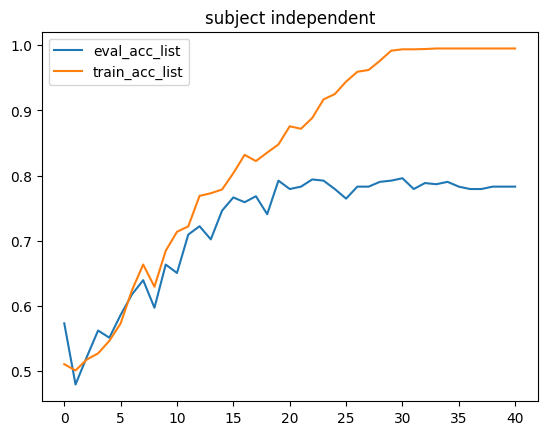

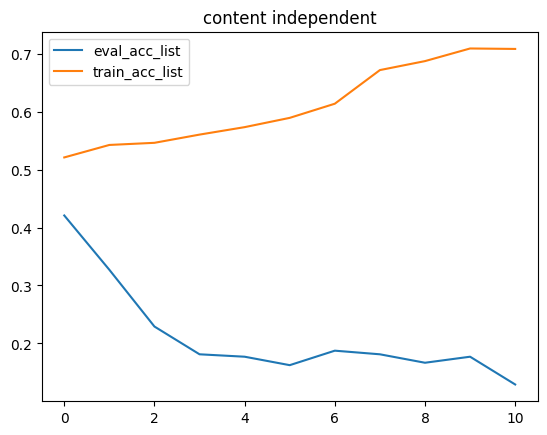

In [73]:
print(save_info_dict['Dilation_exp1']['test_acc'])
print(save_info_dict['Dilation_exp1']['test_loss'])
print(save_info_dict['Dilation_exp2']['test_acc'])
print(save_info_dict['Dilation_exp2']['test_loss'])

plt.plot(save_info_dict['Dilation_exp1']['eval_acc_list'])
plt.plot(save_info_dict['Dilation_exp1']['train_acc_list'])
plt.legend(['eval_acc_list','train_acc_list'])
plt.title('subject independent')
plt.show()
plt.plot(save_info_dict['Dilation_exp2']['eval_acc_list'])
plt.plot(save_info_dict['Dilation_exp2']['train_acc_list'])
plt.legend(['eval_acc_list','train_acc_list'])
plt.title('content independent')
plt.show()

In [72]:
eeg_input_dimension = 64
env_input_dimension = 768
layers = 3
kernel_size = 5
spatial_filters = 64
dilation_filters = 256
activation = nn.ReLU()
match_model=DilationTransformerModel(
    eeg_input_dimension=eeg_input_dimension,
    env_input_dimension=env_input_dimension,
    layers=layers,
    kernel_size=kernel_size,
    spatial_filters=spatial_filters,
    dilation_filters=dilation_filters,
    activation=activation,
)
exp_name='DilationTransformer_exp1'
save_info_dict[exp_name]=train_test_model(match_model,train_loader=train_loader1,val_loader=val_loader1,
                                          test_loader=test_loader1,exp_name=exp_name,verbose=False)


 22%|████████████████████████▏                                                                                     | 22/100 [07:36<26:58, 20.75s/it, epoch=22, eval_acc=0.956, eval_loss=0.0323, train_acc=0.995, train_loss=0.0315]


Early stopping


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.67it/s, batch_idx=19, epoch=None, eval=eval, match_loss=0.104, mean_acc=0.975]


In [77]:
match_model=DilationTransformerModel(
    eeg_input_dimension=eeg_input_dimension,
    env_input_dimension=env_input_dimension,
    layers=layers,
    kernel_size=kernel_size,
    spatial_filters=spatial_filters,
    dilation_filters=dilation_filters,
    activation=activation,
)
exp_name='DilationTransformer_exp2'
save_info_dict[exp_name]=train_test_model(match_model,train_loader=train_loader2,val_loader=val_loader2,
                                          test_loader=test_loader2,exp_name=exp_name,verbose=False)

 10%|███████████▍                                                                                                      | 10/100 [03:36<32:26, 21.63s/it, epoch=10, eval_acc=0.352, eval_loss=28, train_acc=0.996, train_loss=0.0296]


Early stopping


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.23it/s, batch_idx=14, epoch=None, eval=eval, match_loss=0.652, mean_acc=0.467]


0.975
0.10442249812185764
0.46875
0.6511591737469037


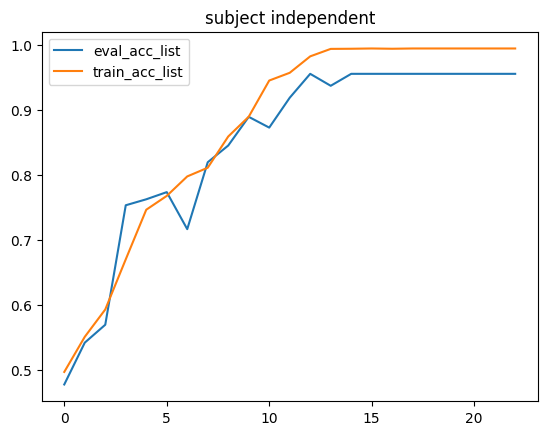

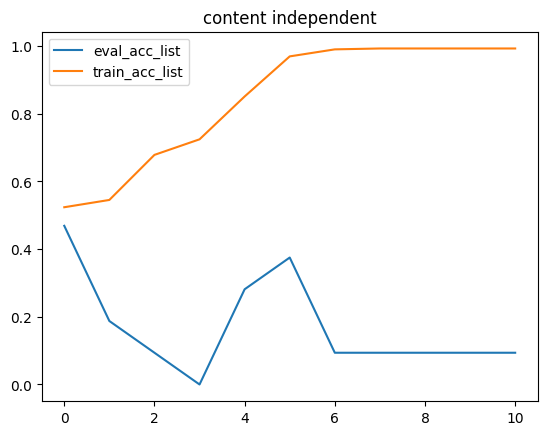

In [75]:
print(save_info_dict['DilationTransformer_exp1']['test_acc'])
print(save_info_dict['DilationTransformer_exp1']['test_loss'])
print(save_info_dict['DilationTransformer_exp2']['test_acc'])
print(save_info_dict['DilationTransformer_exp2']['test_loss'])

plt.plot(save_info_dict['DilationTransformer_exp1']['eval_acc_list'])
plt.plot(save_info_dict['DilationTransformer_exp1']['train_acc_list'])
plt.legend(['eval_acc_list','train_acc_list'])
plt.title('subject independent')
plt.show()
plt.plot(save_info_dict['DilationTransformer_exp2']['eval_acc_list'])
plt.plot(save_info_dict['DilationTransformer_exp2']['train_acc_list'])
plt.legend(['eval_acc_list','train_acc_list'])
plt.title('content independent')
plt.show()

In [ ]:
eeg_input_dimension = 64
env_input_dimension = 768
spatial_filters = 768
layers=3
match_model=CNNTransformerModel(
    eeg_input_dimension=eeg_input_dimension,
    env_input_dimension=env_input_dimension,
    layers=layers,
    spatial_filters=spatial_filters,
)
exp_name='CNNTransformerModel_exp1'
save_info_dict[exp_name]=train_test_model(match_model,train_loader=train_loader1,val_loader=val_loader1,
                                          test_loader=test_loader1,exp_name=exp_name,verbose=False)
match_model=CNNTransformerModel(
    eeg_input_dimension=eeg_input_dimension,
    env_input_dimension=env_input_dimension,
    layers=layers,
    spatial_filters=spatial_filters,
)
exp_name='CNNTransformerModel_exp2'
save_info_dict[exp_name]=train_test_model(match_model,train_loader=train_loader2,val_loader=val_loader2,
                                          test_loader=test_loader2,exp_name=exp_name,verbose=False)

 13%|██████████████▌                                                                                                 | 13/100 [04:04<27:45, 19.14s/it, epoch=12, eval_acc=0.866, eval_loss=0.375, train_acc=0.905, train_loss=0.401]